**Tech Challenge 3: Arquitetura ML e Aprendizado**

*Problema a ser resolvido*

Identificar a correlação entre dados de usuário (idade, gênero, nacionalidade, ocupação) e preferência por filmes e sua avaliação.
A partir desse modelo, seré criada uma API que poderá receber dois inputs difentes:

1. Dados pertencentes a uma pessoa (idade, gênero, nacionalidade) e partir deles e do modelo treinado ser capaz de sugerir filmes em que poderiam potencialmente ter interesse.

2. Dados relacionados a um filmes (tempo de duração, gêneros, ano de lançamento) e partir deles e do modelo treinado ser capaz de indicar o grupo de maior interesse, para que um time de marketing, por exemplo saiba pra onde direcionar as campanhas

*Conjunto de Dados*

Usaremos o grupo de dados do Movielens para esse caso de estudo (https://files.grouplens.org/datasets/movielens/)

In [64]:
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install xgboost

4631.93s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


4637.90s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


4643.74s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


4649.59s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [65]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import zipfile
import re
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Perceptron
from sklearn.metrics import mean_absolute_error,mean_squared_error, mean_absolute_percentage_error,confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

PEDRO: adicionar a ação de download do dataset

In [66]:
with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [67]:
user_data = pd.read_csv('dataset/ml-1m/users.dat',sep='::',header=None,names=['userid','gender','age','occupation','zipcode'],encoding='iso-8859-2')
movie_data = pd.read_csv('dataset/ml-1m/movies.dat',sep='::',header=None,names=['movieid','title','genres'],encoding='iso-8859-2')
ratings_data = pd.read_csv('dataset/ml-1m/ratings.dat',sep='::',header=None,usecols=[0,1,2],names=['userid','movieid','rating'],encoding='iso-8859-2')


/var/folders/51/ny7h227s03q0h23r__06_znh0000gn/T/ipykernel_7414/4052381238.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  user_data = pd.read_csv('dataset/ml-1m/users.dat',sep='::',header=None,names=['userid','gender','age','occupation','zipcode'],encoding='iso-8859-2')
/var/folders/51/ny7h227s03q0h23r__06_znh0000gn/T/ipykernel_7414/4052381238.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movie_data = pd.read_csv('dataset/ml-1m/movies.dat',sep='::',header=None,names=['movieid','title','genres'],encoding='iso-8859-2')
/var/folders/51/ny7h227s03q0h23r__06_znh0000gn/T/ipykernel_7414/4052381238.p

Ao analisar os dados, podemos perceber que possuímos um ratio desbalanceado entre usuários homens (M) e usuárias mulheres (F).

<Axes: ylabel='count'>

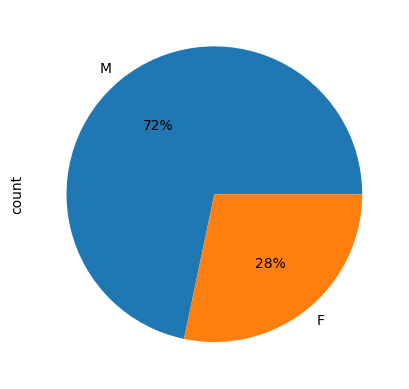

In [68]:
user_data['gender'].value_counts().plot(kind='pie', autopct='%1.0f%%')

Antes de prosseguirmos uma outra informação que é interessante de analisarmos é a distribuição etária de nossos usuários. Vale a pena resaltar que a coluda idade (age) já está "normalizada", obedecendo a seguinte proporção:
*  1:  Mais novos que 18 anos
* 18:  18-24 anos
* 25:  25-34 anos
* 35:  35-44 anos
* 45:  45-49 anos
* 50:  50-55 anos
* 56:  56+ anos

array([<Axes: title={'center': 'F'}, ylabel='Frequency'>,
       <Axes: title={'center': 'M'}, ylabel='Frequency'>], dtype=object)

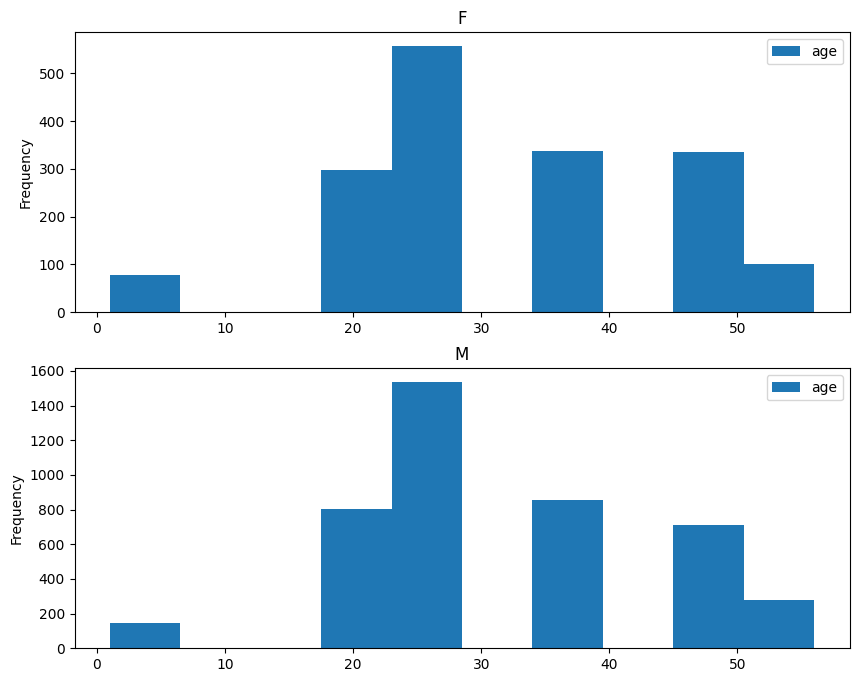

In [69]:
user_data.plot.hist(column=["age"], by="gender", figsize=(10, 8))

Ao analisarmos os dados,mais precisamente a coluna *genres* do dataset de Filmes, é possível perceber que temos um problema de 'Multi-Label' nos nossos dados, onde um filme pode pertencer a 1 ou N gêneros de filmes. Para contornarmos essa situação, iremos converter essa coluna para uma lista de string:

In [70]:
movie_data["release_year"] = [int(re.search(r'\((\d{4})\)', x).group(1)) for x in movie_data["title"]]
movie_data['genres'] = movie_data["genres"].str.split("|")

Em seguida, utilizaremos o **MultiLabelBinarizer** para transformar essa coluna em uma matriz binária

In [71]:
mlb = MultiLabelBinarizer()
encoded_data = mlb.fit_transform(movie_data['genres'])
dados_encodados = pd.DataFrame(encoded_data,columns=mlb.classes_)

E finalmente concatenaremos esse novo dataframe ao "original", podendo assim excluir a coluna '*genres*' de nossos dados.

In [72]:
movie_data = pd.concat([movie_data,dados_encodados],axis=1)
movie_data = movie_data.drop(['genres'],axis=1)
movie_data.head()

,movieid,title,release_year,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Partindo de um princípio parecido, a coluna Gender do dataset de usuário que está dividido em M e F, pode ser alterada um LabelEncoder para facilitar nosso treinamento de modelos.

In [73]:
label_encoder = LabelEncoder()
user_data['gender'] = label_encoder.fit_transform(user_data['gender'])

PEDRO: Salvar aqui os dois datasets user_data e movie_data

**"Mergeando" os datasets**

Antes de começarmos a testar quais modelos podem nos ajudar a solucionar o nosso problema, ou até mesmo antes de padronizarmos/tratarmos os nossos dados, iremos criar um quarto Dataset, que irá conter o todo do cenário com o qual pretendemos trabalhar

In [74]:
dados_completos = pd.merge(user_data, ratings_data, on='userid')
dados_completos = pd.merge(dados_completos, movie_data, on='movieid')
dados_completos.head()

,userid,gender,age,occupation,zipcode,movieid,rating,title,release_year,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,1,10,48067,1193,5,One Flew Over the Cuckoo's Nest (1975),1975,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,10,48067,661,3,James and the Giant Peach (1996),1996,0,...,0,0,0,1,0,0,0,0,0,0
2,1,0,1,10,48067,914,3,My Fair Lady (1964),1964,0,...,0,0,0,1,0,1,0,0,0,0
3,1,0,1,10,48067,3408,4,Erin Brockovich (2000),2000,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,10,48067,2355,5,"Bug's Life, A (1998)",1998,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
dados_modelo = dados_completos.drop(['movieid','userid','title','zipcode'],axis=1)


Agora, podemos começar a nossa jornada de validação e testes de alguma modelos, como temos a coluna rating, que funciona como a nota do especialista, podemos começar com um aprendizado supervisionado. Começaremos com modelos de regressão para tal. Contudo, antes de comerçamos com os treinamentos, iremos separar nossos dados em dados de treino e dados de teste, utilizando o train_test_split do scikitlearn

Primeiramente separamos os nossos dados X e Y, e já criaremos uma variável de seed que será o controlador de qualquer randomização que utilizarmos

Agora separamos a parcela de teste e a parcela de treino

In [76]:
x = dados_modelo.drop(columns=['rating'])
y = dados_modelo['rating']
SEED = 42

In [77]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)


Já deixaremos aqui, uma função para a avaliação do Modelo e uma função para busca dos melhores hiper parâmetros

In [78]:
def avalia_modelo(y_test,y_pred, tipoModelo):
    mse = mean_squared_error(y_test,y_pred, squared=True)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test,y_pred)

    print(f'{tipoModelo} - MSE: {mse} RMSE: {rmse} MAPE: {mape}')

def procura_melhores_parametros(model, parametros,treino_x,treino_y):
    grid_search = GridSearchCV(estimator=model,
                           param_grid=parametros,
                           cv=5,
                           scoring='neg_mean_absolute_percentage_error',
                           n_jobs=-1)

    #busca a melhor combinação de parametros, baseado nos dados de teste
    grid_search.fit(treino_x, treino_y)

    # retorna o melhor modelo
    melhor_modelo = grid_search.best_estimator_
    return melhor_modelo  


***REGRESSÂO LINEAR***

Começaremos os nossos testes, utilizando o LinearRegression do scikit-learn

In [79]:
linear_regressor = LinearRegression()
linear_regressor.fit(x_train, y_train)
linear_pred = linear_regressor.predict(x_test)

***KNN Regressor***

Agora utilizaremos o KNN Regressor, contudo para esse modelo utilizaremos a função previamente criada para chegar no melhor número de "vizinhos"

In [80]:

parametros = {
    'n_neighbors': [2,5,8,10],
    'metric':['euclidean']
}

model = procura_melhores_parametros(KNeighborsRegressor(),parametros,x_train,y_train)
knnregressor_pred = model.predict(x_test)

***Support Vector Machine: Linear***

O SVM é uma ferramenta robusta, poderosa e versátil. Indicada para problemas mais complexos e alcançar alta precisão, vamos ver como se sai em nosso caso de estudo. Mais uma vez obtendo o melhor modelo a partir do gridsearch

In [ ]:
parametros = {
    'C': [5,25,60, 100]
}

model = procura_melhores_parametros(SVR(kernel='linear'),parametros,x_train,y_train)
svm_pred =  model.predict(x_test)

***Árvore de Decisão***

A árvore de decisão contrói uma estrutura hierárquica de regras que dividem em subconjuntos baseados nas características, facilitando a identificação

In [82]:
model = DecisionTreeClassifier()

model.fit(x_train, y_train)
decision_tree_pred = model.predict(x_test)

***Redes Neurais Artificiais (RNA)***

As redes neurais artificiais são modelos computacionais que imitam o funcionamento do cérebro humano para resolver problemas complexos

In [83]:
model = Perceptron()
model.fit(x_train, y_train)
perceptron_pred = model.predict(x_test)

***Multilayer Perceptron (MLP)***

O multilayer percepton é um modelo de rene neural artificial com múltiplas camadas

In [84]:
model = MLPClassifier()
model.fit(x_train, y_train)
mlp_pred = model.predict(x_test)

***XGBoost***

Finalizaremos nossos testes com diferente tipos de estimadores, fazendo uso do XGBoost. É um dos mais utilizados pelo mercado e academia, funciona atráves da construção sequencial de N árvores de decisão mais fracas, onde cada árvore aprende com o erro da anterior.

In [ ]:
parametros = {
    "n_estimators": [20, 50, 100],
    "max_depth": [3, 6, 8],
    "learning_rate": [0.1]
}

model = procura_melhores_parametros(XGBRegressor(),parametros,x_train,y_train)

xgboost_pred = model.predict(x_test)

Agora, uma vez que temos os estimadores treinados, mas definir através do MAPE. Qual modelo performa melhor em nosso cenário de estudo:

In [62]:
avalia_modelo(y_test,linear_pred,"LinearRegression")
avalia_modelo(y_test,knnregressor_pred,"KNN Regressor")
avalia_modelo(y_test,svm_pred,"SVM Linear")
avalia_modelo(y_test,xgboost_pred,"XGBoost")
avalia_modelo(y_test,decision_tree_pred,"DecisionTree")
avalia_modelo(y_test,perceptron_pred,"Perceptron")
avalia_modelo(y_test,mlp_pred,"MLP")

LinearRegression - MSE: 1.1773485999027848 RMSE: 1.08505695698557 MAPE: 0.36286106463543266
SVM Linear - MSE: 1.1773485999027848 RMSE: 1.08505695698557 MAPE: 0.36286106463543266
DecisionTree - MSE: 1.608462222933184 RMSE: 1.2682516402249138 MAPE: 0.3635406564621429
Perceptron - MSE: 3.263289709161076 RMSE: 1.8064577795124568 MAPE: 0.648886233890883


/Users/cristianoreis/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cristianoreis/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cristianoreis/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/cristianoreis/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in ve

Agora que sabemos que o melhor estimador pro nosso cenário de estudo, foi o {INSERIR AQUI MENOR O DE MENOR MAPE} cujo o MAPE foi de {INSERIR VALOR DO MAPE}. Lembrando que poderiamos tentar otimizar ainda mais, utilizando uma gama maior de hyper parâmetros, contudo poderiamos cair em cenário onde ficariamos extremamente especializados com nossos dados de teste (Overfitting).

Podemos finalmente exportar nosso modelo e avançar para a próxima etapa que é construir uma API que consiga predizer para um usuário de acordo com diferentes dados de entrada.